This model is used for the training of the GAN that generates the P300 samples. Remember to check the file locations where you save the pictures and checkpoints.

In [1]:
from scipy.io import loadmat
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatreader import read_mat
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import eeg_funcs

In [2]:
from scipy.io import loadmat
import numpy as np
import mne

In [3]:
#filepath_2 = glob('data/train/*.mat')
filepath_3 = glob('data/Three/Train/*.mat')
#d_array_2, d_labels_2 = eeg_funcs.get_comp2_array(filepath_2, True, True)
d_array_3, d_labels_3 = eeg_funcs.get_comp3_array(filepath_3, True, True)
#print(d_array_2.shape)
print(d_array_3.shape)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 0.10, 20.00 Hz: -6.02, -6.02 dB

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
179 events found
Event IDs: [1 2]
Not setting metadata
179 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 179 events and 160 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_chann

In [5]:
#d_array_2 = d_array_2*1e6
d_array_3 = d_array_3*1e6
#print(np.min(d_array_2), np.max(d_array_2))
print(np.min(d_array_3), np.max(d_array_3))
#dt_array_2 = normalize_data(d_array_2)
dt_array_3 = eeg_funcs.normalize_data_f32(d_array_3)
#print(np.min(dt_array_2), np.max(dt_array_2))
print(np.min(dt_array_3), np.max(dt_array_3))

-218.87578913146473 272.64014957482135
-1.0 1.0


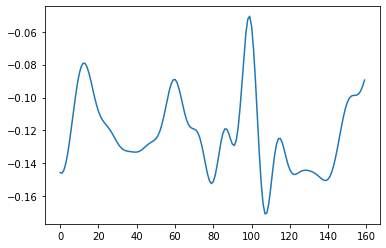

In [28]:
plt.plot(dt_array_3[37748,:,5])

In [7]:
p_array = eeg_funcs.get_P300_from_array3(dt_array_3)
#p_array shape should be (5071, 160, 8)
print(p_array.shape)

(5071, 160, 8)


In [8]:
d_array = tf.expand_dims(p_array, axis=3)
print(d_array.shape)
print(type(d_array))

(5071, 160, 8, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [9]:
data_array_2 = tf.convert_to_tensor(d_array, dtype=tf.float32)

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(data_array_2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

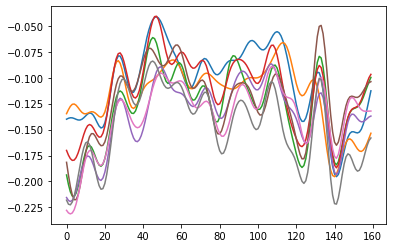

In [11]:
plt.plot(d_array[4358,:,:,0])

In [37]:
for i in range(5500):
            img = d_array[i]
            img1 = img[:,:,0]
            img2 = img[:,5,:]
            plt.plot(img1)
            plt.savefig("OriginalimgData/full/generated_img_%d.png" % (i))
            plt.clf()

<Figure size 432x288 with 0 Axes>

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [13]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=data_array_2.shape[1:]),
        layers.Conv2D(64, kernel_size=(4,4), strides=(2,2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv2D(128, kernel_size=(4,4), strides=(2,2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 4, 64)         1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 4, 64)         0         
                                                                 
 dropout (Dropout)           (None, 80, 4, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 2, 128)        131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 2, 128)        0         
                                                                 
 dropout_1 (Dropout)         (None, 40, 2, 128)        0         
                                                                 
 flatten (Flatten)           (None, 10240)           

In [14]:
latent_dim = 160

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(10*1*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((10, 1, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1, (4, 4), strides=(2, 1), padding='same', use_bias=False, activation='tanh'),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2560)              409600    
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2560)              0         
                                                                 
 reshape (Reshape)           (None, 10, 1, 256)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 2, 128)       524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 2, 128)       51

In [15]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [16]:
# Creating a monitor that saves two sample pictures of the generated data, every epoch.
# remember to check the filepaths!

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images.numpy()
        for i in range(self.num_img):
            img = generated_images[i]
            img1 = img[:,:,0]
            img2 = img[:,5,:]
            plt.plot(img2)
            plt.savefig("C:/Users/telab/Downloads/datafiles/P300/single/generated_img_%03d_%d.png" % (epoch, i))
            plt.clf()
            plt.plot(img1)
            plt.savefig("C:/Users/telab/Downloads/datafiles/P300/full/generated_img_%03d_%d.png" % (epoch, i))
            plt.clf()
            ##img = keras.preprocessing.image.array_to_img(generated_images[i])
            ##img.save("generated_img_%03d_%d.png" % (epoch, i))

In [17]:
steps = len(d_array) / BATCH_SIZE
save_period = 25

#remember to check the filepath!
checkpoint_filepath = 'C:/Users/telab/Downloads/datafiles/P300/checkpoint/checkpoint.{epoch:02d}'

#Creating a modelcheckpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='g_loss',
    mode='min',
    save_freq=int(save_period * steps),
    save_best_only=False)

In [18]:
epochs = 5000

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

# use the two lines below if you want to resume training after stopping
#latest = tf.train.latest_checkpoint('C:/Users/telab/Downloads/datafiles/Unfiltered/P300/checkpoint')
#gan.load_weights(latest)

gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim), model_checkpoint_callback]
)

Epoch 1/1200
80/80 [==============================] - 6s 13ms/step - d_loss: 0.6859 - g_loss: 0.7649
Epoch 2/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6860 - g_loss: 0.7664
Epoch 3/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6845 - g_loss: 0.7660
Epoch 4/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6854 - g_loss: 0.7618
Epoch 5/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6857 - g_loss: 0.7657
Epoch 6/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6852 - g_loss: 0.7671
Epoch 7/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6847 - g_loss: 0.7639
Epoch 8/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6861 - g_loss: 0.7669
Epoch 9/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6852 - g_loss: 0.7708
Epoch 10/1200
80/80 [==============================] - 1s 11ms/step - d_loss: 0.6869 - g_lo

<Figure size 432x288 with 0 Axes>